# COSMOS Selection Functions
## Depth maps and selection functions

The simplest selection function available is the field MOC which specifies the area for which there is Herschel data. Each pristine catalogue also has a MOC defining the area for which that data is available.

The next stage is to provide mean flux standard deviations which act as a proxy for the catalogue's 5$\sigma$ depth

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
017bb1e (Mon Jun 18 14:58:59 2018 +0100)
This notebook was executed on: 
2019-04-02 17:11:18.376232


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
import numpy as np
from pymoc import MOC
import healpy as hp
#import pandas as pd #Astropy has group_by function so apandas isn't required.
import seaborn as sns

import warnings
#We ignore warnings - this is a little dangerous but a huge number of warnings are generated by empty cells later
warnings.filterwarnings('ignore')

from herschelhelp_internal.utils import inMoc, coords_to_hpidx, flux_to_mag
from herschelhelp_internal.masterlist import find_last_ml_suffix, nb_ccplots

from astropy.io.votable import parse_single_table

In [3]:
FIELD = 'COSMOS'
#FILTERS_DIR = "/Users/rs548/GitHub/herschelhelp_python/database_builder/filters/"
FILTERS_DIR = "/opt/herschelhelp_python/database_builder/filters/"

In [4]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = find_last_ml_suffix()
#SUFFIX = "20171016"

master_catalogue_filename = "master_catalogue_{}_{}.fits".format(FIELD.lower(), SUFFIX)
master_catalogue = Table.read("{}/{}".format(OUT_DIR, master_catalogue_filename))

print("Depth maps produced using: {}".format(master_catalogue_filename))

ORDER = 10
#TODO write code to decide on appropriate order

field_moc = MOC(filename="../../dmu2/dmu2_field_coverages/{}_MOC.fits".format(FIELD))

Depth maps produced using: master_catalogue_cosmos_20190402.fits


In [5]:
# Remove sources whose signal to noise ratio is less than five as these will have been selected using forced 
# photometry and so the errors will not refelct the RMS of the map 
for n,col in enumerate(master_catalogue.colnames):
    if col.startswith("f_"):
        err_col = "ferr{}".format(col[1:])
        errs = master_catalogue[err_col]
        fluxes = master_catalogue[col]
        mask = fluxes/errs < 5.0
        master_catalogue[col][mask] = np.nan
        master_catalogue[err_col][mask] = np.nan

## I - Group masterlist objects by healpix cell and calculate depths
We add a column to the masterlist catalogue for the target order healpix cell <i>per object</i>.

In [6]:
#Add a column to the catalogue with the order=ORDER hp_idx
master_catalogue.add_column(Column(data=coords_to_hpidx(master_catalogue['ra'],
                                                       master_catalogue['dec'],
                                                       ORDER), 
                                   name="hp_idx_O_{}".format(str(ORDER))
                                  )
                           )

In [7]:
# Convert catalogue to pandas and group by the order=ORDER pixel

group = master_catalogue.group_by(["hp_idx_O_{}".format(str(ORDER))])

In [8]:
#Downgrade the groups from order=ORDER to order=13 and then fill out the appropriate cells
#hp.pixelfunc.ud_grade([2599293, 2599294], nside_out=hp.order2nside(13))

## II Create a table of all Order=13 healpix cells in the field and populate it
We create a table with every order=13 healpix cell in the field MOC. We then calculate the healpix cell at lower order that the order=13 cell is in. We then fill in the depth at every order=13 cell as calculated for the lower order cell that that the order=13 cell is inside.

In [9]:
depths = Table()
depths['hp_idx_O_13'] = list(field_moc.flattened(13))

In [10]:
depths[:10].show_in_notebook()

idx,hp_idx_O_13
0,448004096
1,448004097
2,448004098
3,448004099
4,448004100
5,448004101
6,448004102
7,448004103
8,448004104
9,448004105


In [11]:
depths.add_column(Column(data=hp.pixelfunc.ang2pix(2**ORDER,
                     hp.pixelfunc.pix2ang(2**13, depths['hp_idx_O_13'], nest=True)[0],
                     hp.pixelfunc.pix2ang(2**13, depths['hp_idx_O_13'], nest=True)[1],
                     nest = True),
                     name="hp_idx_O_{}".format(str(ORDER))
                        )
                 )

In [12]:
depths[:10].show_in_notebook()

idx,hp_idx_O_13,hp_idx_O_10
0,448004096,7000064
1,448004097,7000064
2,448004098,7000064
3,448004099,7000064
4,448004100,7000064
5,448004101,7000064
6,448004102,7000064
7,448004103,7000064
8,448004104,7000064
9,448004105,7000064


In [13]:
for col in master_catalogue.colnames:
    if col.startswith("f_"):
        errcol = "ferr{}".format(col[1:])
        depths = join(depths, 
                      group["hp_idx_O_{}".format(str(ORDER)), errcol].groups.aggregate(np.nanmean),
                     join_type='left')
        depths[errcol].name = errcol + "_mean"
        depths = join(depths, 
                      group["hp_idx_O_{}".format(str(ORDER)), col].groups.aggregate(lambda x: np.nanpercentile(x, 90.)),
                     join_type='left')
        depths[col].name = col + "_p90"

depths[:10].show_in_notebook()

idx,hp_idx_O_13,hp_idx_O_10,ferr_ap_vista_ks_mean,f_ap_vista_ks_p90,ferr_vista_ks_mean,f_vista_ks_p90,ferr_ap_vista_y_mean,f_ap_vista_y_p90,ferr_vista_y_mean,f_vista_y_p90,ferr_ap_vista_h_mean,f_ap_vista_h_p90,ferr_vista_h_mean,f_vista_h_p90,ferr_ap_vista_j_mean,f_ap_vista_j_p90,ferr_vista_j_mean,f_vista_j_p90,ferr_ap_suprime_b_mean,f_ap_suprime_b_p90,ferr_suprime_b_mean,f_suprime_b_p90,ferr_ap_suprime_v_mean,f_ap_suprime_v_p90,ferr_suprime_v_mean,f_suprime_v_p90,ferr_ap_suprime_ip_mean,f_ap_suprime_ip_p90,ferr_suprime_ip_mean,f_suprime_ip_p90,ferr_ap_suprime_rc_mean,f_ap_suprime_rc_p90,ferr_suprime_rc_mean,f_suprime_rc_p90,ferr_ap_suprime_zp_mean,f_ap_suprime_zp_p90,ferr_suprime_zp_mean,f_suprime_zp_p90,ferr_ap_suprime_zpp_mean,f_ap_suprime_zpp_p90,ferr_suprime_zpp_mean,f_suprime_zpp_p90,ferr_ap_suprime_ia484_mean,f_ap_suprime_ia484_p90,ferr_suprime_ia484_mean,f_suprime_ia484_p90,ferr_ap_suprime_ia527_mean,f_ap_suprime_ia527_p90,ferr_suprime_ia527_mean,f_suprime_ia527_p90,ferr_ap_suprime_ia624_mean,f_ap_suprime_ia624_p90,ferr_suprime_ia624_mean,f_suprime_ia624_p90,ferr_ap_suprime_ia679_mean,f_ap_suprime_ia679_p90,ferr_suprime_ia679_mean,f_suprime_ia679_p90,ferr_ap_suprime_ia738_mean,f_ap_suprime_ia738_p90,ferr_suprime_ia738_mean,f_suprime_ia738_p90,ferr_ap_suprime_ia767_mean,f_ap_suprime_ia767_p90,ferr_suprime_ia767_mean,f_suprime_ia767_p90,ferr_ap_suprime_ib427_mean,f_ap_suprime_ib427_p90,ferr_suprime_ib427_mean,f_suprime_ib427_p90,ferr_ap_suprime_ib464_mean,f_ap_suprime_ib464_p90,ferr_suprime_ib464_mean,f_suprime_ib464_p90,ferr_ap_suprime_ib505_mean,f_ap_suprime_ib505_p90,ferr_suprime_ib505_mean,f_suprime_ib505_p90,ferr_ap_suprime_ib574_mean,f_ap_suprime_ib574_p90,ferr_suprime_ib574_mean,f_suprime_ib574_p90,ferr_ap_suprime_ib709_mean,f_ap_suprime_ib709_p90,ferr_suprime_ib709_mean,f_suprime_ib709_p90,ferr_ap_suprime_ib827_mean,f_ap_suprime_ib827_p90,ferr_suprime_ib827_mean,f_suprime_ib827_p90,ferr_ap_suprime_nb711_mean,f_ap_suprime_nb711_p90,ferr_suprime_nb711_mean,f_suprime_nb711_p90,ferr_ap_suprime_nb816_mean,f_ap_suprime_nb816_p90,ferr_suprime_nb816_mean,f_suprime_nb816_p90,ferr_ap_wfc3_f140w_mean,f_ap_wfc3_f140w_p90,ferr_wfc3_f140w_mean,f_wfc3_f140w_p90,ferr_ap_wfc3_f160w_mean,f_ap_wfc3_f160w_p90,ferr_wfc3_f160w_mean,f_wfc3_f160w_p90,ferr_ap_megacam_u_mean,f_ap_megacam_u_p90,ferr_megacam_u_mean,f_megacam_u_p90,ferr_ap_megacam_g_mean,f_ap_megacam_g_p90,ferr_megacam_g_mean,f_megacam_g_p90,ferr_ap_megacam_r_mean,f_ap_megacam_r_p90,ferr_megacam_r_mean,f_megacam_r_p90,ferr_ap_megacam_i_mean,f_ap_megacam_i_p90,ferr_megacam_i_mean,f_megacam_i_p90,ferr_ap_megacam_z_mean,f_ap_megacam_z_p90,ferr_megacam_z_mean,f_megacam_z_p90,ferr_ap_decam_g_mean,f_ap_decam_g_p90,ferr_decam_g_mean,f_decam_g_p90,ferr_ap_decam_r_mean,f_ap_decam_r_p90,ferr_decam_r_mean,f_decam_r_p90,ferr_ap_decam_z_mean,f_ap_decam_z_p90,ferr_decam_z_mean,f_decam_z_p90,ferr_ap_omegacam_u_mean,f_ap_omegacam_u_p90,ferr_omegacam_u_mean,f_omegacam_u_p90,ferr_ap_omegacam_g_mean,f_ap_omegacam_g_p90,ferr_omegacam_g_mean,f_omegacam_g_p90,ferr_ap_omegacam_r_mean,f_ap_omegacam_r_p90,ferr_omegacam_r_mean,f_omegacam_r_p90,ferr_ap_omegacam_i_mean,f_ap_omegacam_i_p90,ferr_omegacam_i_mean,f_omegacam_i_p90,ferr_ap_ukidss_y_mean,f_ap_ukidss_y_p90,ferr_ukidss_y_mean,f_ukidss_y_p90,ferr_ap_ukidss_j_mean,f_ap_ukidss_j_p90,ferr_ukidss_j_mean,f_ukidss_j_p90,ferr_ap_ukidss_h_mean,f_ap_ukidss_h_p90,ferr_ukidss_h_mean,f_ukidss_h_p90,ferr_ap_ukidss_k_mean,f_ap_ukidss_k_p90,ferr_ukidss_k_mean,f_ukidss_k_p90,ferr_ap_wircam_j_mean,f_ap_wircam_j_p90,ferr_wircam_j_mean,f_wircam_j_p90,ferr_ap_gpc1_g_mean,f_ap_gpc1_g_p90,ferr_gpc1_g_mean,f_gpc1_g_p90,ferr_ap_gpc1_r_mean,f_ap_gpc1_r_p90,ferr_gpc1_r_mean,f_gpc1_r_p90,ferr_ap_gpc1_i_mean,f_ap_gpc1_i_p90,ferr_gpc1_i_mean,f_gpc1_i_p90,ferr_ap_gpc1_z_mean,f_ap_gpc1_z_p90,ferr_gpc1_z_mean,f_gpc1_z_p90,ferr_ap_gpc1_y_mean,f_ap_gpc1_y_p90,ferr_gpc1_y_mean,f_gpc1_y_p90,ferr_ap_suprime_g_mean,f_ap_suprime_g_p90,ferr_suprime_g_mean,f_suprime_g_p90,ferr_ap_suprim

## III - Save the depth map table

In [14]:
depths.write("{}/depths_{}_{}.fits".format(OUT_DIR, FIELD.lower(), SUFFIX), overwrite=True)

## IV - Overview plots

### IV.a - Filters
First we simply plot all the filters available on this field to give an overview of coverage.

In [15]:
tot_bands = [column[2:] for column in master_catalogue.colnames 
             if (column.startswith('f_') & ~column.startswith('f_ap_'))]
ap_bands = [column[5:] for column in master_catalogue.colnames 
            if column.startswith('f_ap_') ]
bands = set(tot_bands) | set(ap_bands)
bands

{'acs_f606w',
 'acs_f814w',
 'decam_g',
 'decam_r',
 'decam_z',
 'gpc1_g',
 'gpc1_i',
 'gpc1_r',
 'gpc1_y',
 'gpc1_z',
 'irac_i1',
 'irac_i2',
 'irac_i3',
 'irac_i4',
 'megacam_g',
 'megacam_i',
 'megacam_r',
 'megacam_u',
 'megacam_z',
 'omegacam_g',
 'omegacam_i',
 'omegacam_r',
 'omegacam_u',
 'suprime_b',
 'suprime_g',
 'suprime_i',
 'suprime_ia484',
 'suprime_ia527',
 'suprime_ia624',
 'suprime_ia679',
 'suprime_ia738',
 'suprime_ia767',
 'suprime_ib427',
 'suprime_ib464',
 'suprime_ib505',
 'suprime_ib574',
 'suprime_ib709',
 'suprime_ib827',
 'suprime_ip',
 'suprime_n921',
 'suprime_nb711',
 'suprime_nb816',
 'suprime_r',
 'suprime_rc',
 'suprime_v',
 'suprime_y',
 'suprime_z',
 'suprime_zp',
 'suprime_zpp',
 'ukidss_h',
 'ukidss_j',
 'ukidss_k',
 'ukidss_y',
 'vista_h',
 'vista_j',
 'vista_ks',
 'vista_y',
 'wfc3_f125w',
 'wfc3_f140w',
 'wfc3_f160w',
 'wircam_h',
 'wircam_j',
 'wircam_ks'}

Text(0.5, 1.0, 'Passbands on COSMOS')

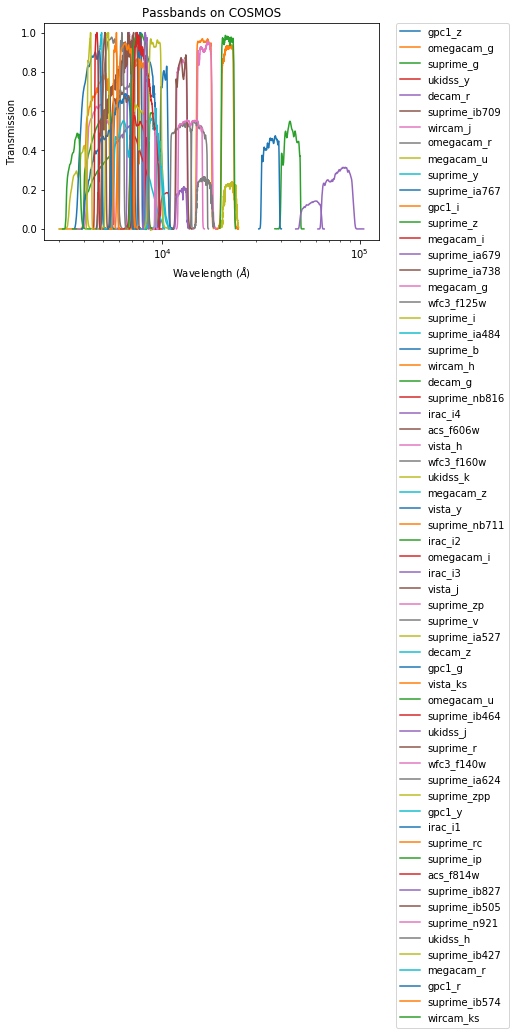

In [16]:
for b in bands:
    plt.plot(Table(data = parse_single_table(FILTERS_DIR + b + '.xml').array.data)['Wavelength']
            ,Table(data = parse_single_table(FILTERS_DIR + b + '.xml').array.data)['Transmission']
            , label=b)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Transmission')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Passbands on {}'.format(FIELD))

### IV.a - Depth overview
Then we plot the mean depths available across the area a given band is available

In [17]:
average_depths = []
for b in ap_bands:
    
    mean_err = np.nanmean(depths['ferr_ap_{}_mean'.format(b)])
    print("{}: mean flux error: {}, 3sigma in AB mag (Aperture): {}".format(b, mean_err, flux_to_mag(3.0*mean_err*1.e-6)[0]))
    average_depths += [('ap_' + b, flux_to_mag(1.0*mean_err*1.e-6)[0], 
                        flux_to_mag(3.0*mean_err*1.e-6)[0], 
                        flux_to_mag(5.0*mean_err*1.e-6)[0])]
    
for b in tot_bands:
    
    mean_err = np.nanmean(depths['ferr_{}_mean'.format(b)])
    print("{}: mean flux error: {}, 3sigma in AB mag (Total): {}".format(b, mean_err, flux_to_mag(3.0*mean_err*1.e-6)[0]))
    average_depths += [(b, flux_to_mag(1.0*mean_err*1.e-6)[0], 
                        flux_to_mag(3.0*mean_err*1.e-6)[0], 
                        flux_to_mag(5.0*mean_err*1.e-6)[0])]
    
average_depths = np.array(average_depths,  dtype=[('band', "<U16"), ('1s', float), ('3s', float), ('5s', float)])
    

vista_ks: mean flux error: 0.17190621320830457, 3sigma in AB mag (Aperture): 24.6189679289975
vista_y: mean flux error: 0.07799079929099993, 3sigma in AB mag (Aperture): 25.47708843509117
vista_h: mean flux error: 0.13332982460119622, 3sigma in AB mag (Aperture): 24.894878593737396
vista_j: mean flux error: 0.0998046816621908, 3sigma in AB mag (Aperture): 25.209319578810884
suprime_b: mean flux error: 0.017149616992134138, 3sigma in AB mag (Aperture): 27.121560800076033
suprime_v: mean flux error: 0.03300917277761061, 3sigma in AB mag (Aperture): 26.41061026099522
suprime_ip: mean flux error: 0.028356851554278903, 3sigma in AB mag (Aperture): 26.57555183892861
suprime_rc: mean flux error: 0.024098184385935344, 3sigma in AB mag (Aperture): 26.75223605560941
suprime_zp: mean flux error: 0.16614545267878372, 3sigma in AB mag (Aperture): 24.65597571483567
suprime_zpp: mean flux error: 0.036040846065525545, 3sigma in AB mag (Aperture): 26.315209419275938
suprime_ia484: mean flux error: 0.03

In [18]:
def FWHM(X,Y):
    
    half_max = max(Y) / 2.
    #find when function crosses line half_max (when sign of diff flips)
    #take the 'derivative' of signum(half_max - Y[])
    d = half_max - Y
    #plot(X,d) #if you are interested
    #find the left and right most indexes
    low_end = X[np.where(d < 0)[0][0]]
    high_end = X[np.where(d < 0)[0][-1]]
    return low_end, high_end, (high_end - low_end)


In [19]:
data = []

for b in ap_bands:
    data += [['ap_' + b, Table(data = parse_single_table(FILTERS_DIR + b +'.xml').array.data)]]
    
for b in tot_bands:
    data += [[b, Table(data = parse_single_table(FILTERS_DIR + b +'.xml').array.data)]]

In [20]:
wav_range = []
for dat in data:
    print(dat[0], FWHM(np.array(dat[1]['Wavelength']), np.array(dat[1]['Transmission'])))
    wav_range += [[dat[0], FWHM(np.array(dat[1]['Wavelength']), np.array(dat[1]['Transmission']))]]


ap_vista_ks (19930.0, 23010.0, 3080.0)
ap_vista_y (9740.0, 10660.0, 920.0)
ap_vista_h (15000.0, 17900.0, 2900.0)
ap_vista_j (11670.0, 13380.0, 1710.0)
ap_suprime_b (3827.0, 4906.0, 1079.0)
ap_suprime_v (4941.6, 5925.8, 984.1997)
ap_suprime_ip (6895.0, 8437.5, 1542.5)
ap_suprime_rc (5919.9, 7079.5, 1159.6001)
ap_suprime_zp (8073.5, 8416.0, 342.5)
ap_suprime_zpp (8499.9, 9883.9, 1384.0)
ap_suprime_ia484 (4733.0, 4961.5, 228.5)
ap_suprime_ia527 (5139.0, 5381.0, 242.0)
ap_suprime_ia624 (6082.5, 6382.0, 299.5)
ap_suprime_ia679 (6613.0, 6948.5, 335.5)
ap_suprime_ia738 (7200.5, 7524.0, 323.5)
ap_suprime_ia767 (7498.0, 7861.0, 363.0)
ap_suprime_ib427 (4158.0, 4365.0, 207.0)
ap_suprime_ib464 (4525.0, 4742.5, 217.5)
ap_suprime_ib505 (4945.0, 5176.0, 231.0)
ap_suprime_ib574 (5626.0, 5898.5, 272.5)
ap_suprime_ib709 (6913.5, 7229.5, 316.0)
ap_suprime_ib827 (8073.5, 8416.0, 342.5)
ap_suprime_nb711 (7085.5, 7158.0, 72.5)
ap_suprime_nb816 (8094.0, 8211.5, 117.5)
ap_wfc3_f140w (12005.91, 15946.44, 3940

Text(0.5, 1.0, 'Depths on COSMOS')

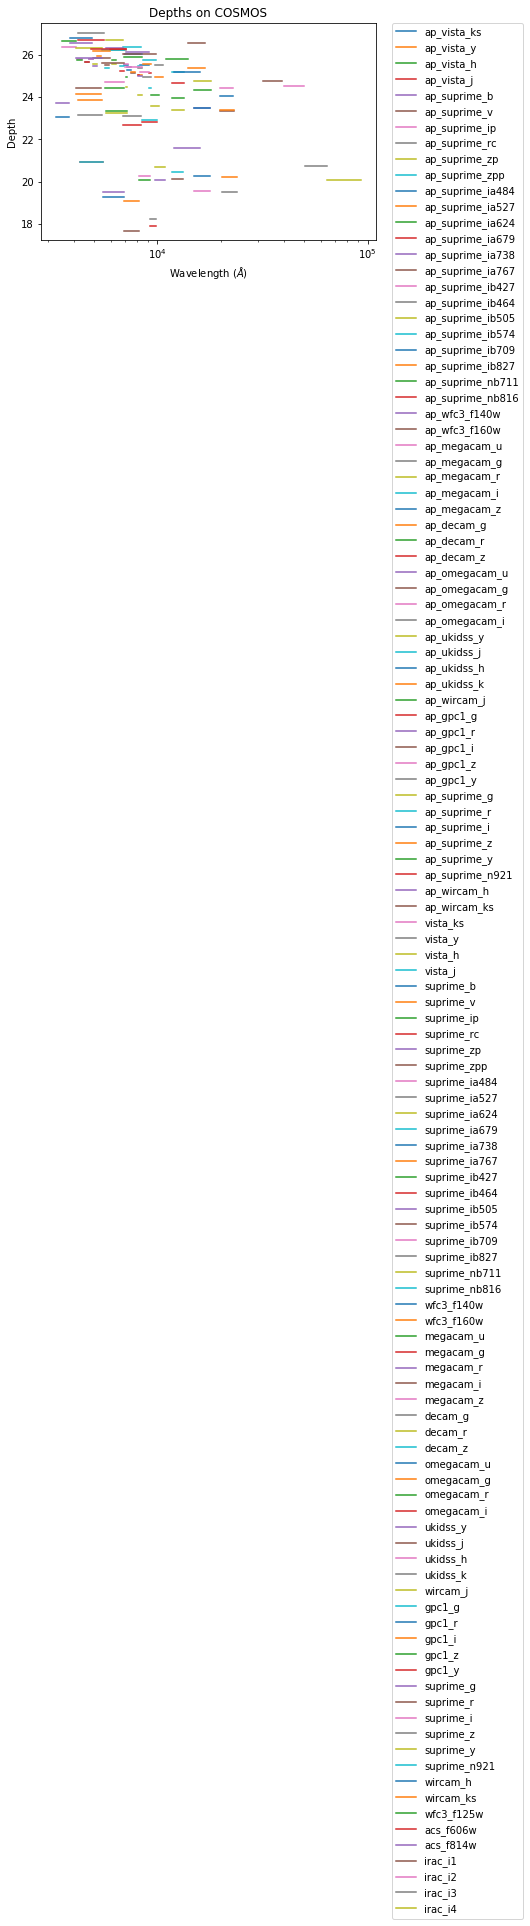

In [21]:
for dat in data:
    wav_deets = FWHM(np.array(dat[1]['Wavelength']), np.array(dat[1]['Transmission']))
    depth = average_depths['5s'][average_depths['band'] == dat[0]]
    #print(depth)
    plt.plot([wav_deets[0],wav_deets[1]], [depth,depth], label=dat[0])
    
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Depth')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Depths on {}'.format(FIELD))

### IV.c - Depth vs coverage comparison

How best to do this? Colour/intensity plot over area? Percentage coverage vs mean depth?

Text(0.5, 1.0, 'Depths (5 $\\sigma$) vs coverage on COSMOS')

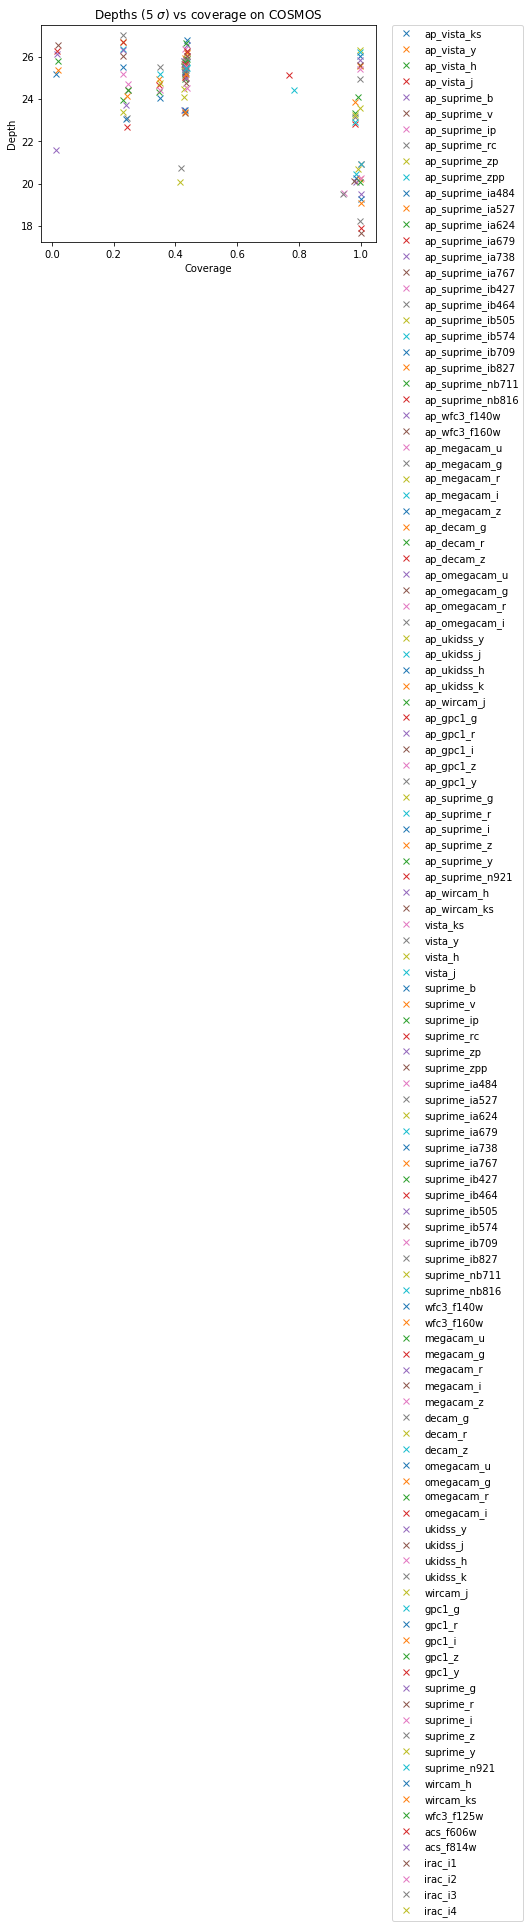

In [22]:
for dat in data:
    wav_deets = FWHM(np.array(dat[1]['Wavelength']), np.array(dat[1]['Transmission']))
    depth = average_depths['5s'][average_depths['band'] == dat[0]]
    #print(depth)
    coverage = np.sum(~np.isnan(depths['ferr_{}_mean'.format(dat[0])]))/len(depths)
    plt.plot(coverage, depth, 'x', label=dat[0])
    
plt.xlabel('Coverage')
plt.ylabel('Depth')
#plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Depths (5 $\sigma$) vs coverage on {}'.format(FIELD))